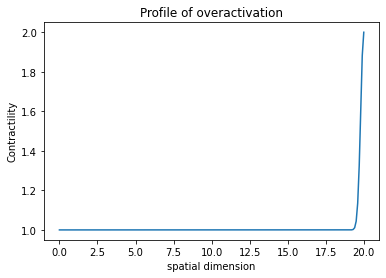

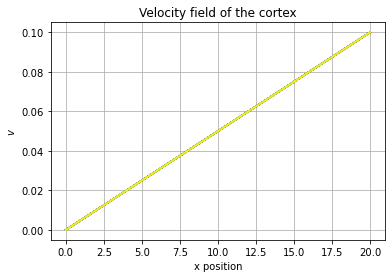

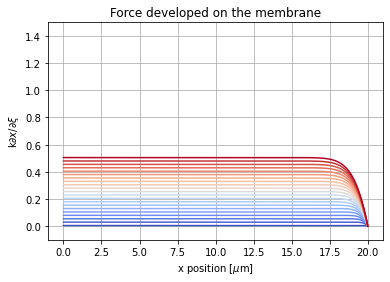

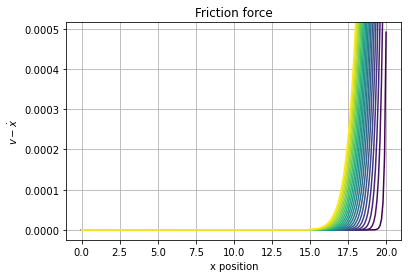

<Figure size 432x288 with 0 Axes>

In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tikzplotlib import save as tikz_save

# %matplotlib notebook
%matplotlib inline

# Physical parameters
k = Constant(10.)                 # [pN/um]
L = 20.                # [um] System size length
eta = Constant(10000)          # [pN s/ um] 2D viscosity of the cortex
mu = Constant(100)              # [pN s/um^3] friction coefficient

imposed_displacement = 0.00 * L    # [um]  imposed displacement 5% of the membrane length

sigma_0 = 0.  # Applied stress 
alpha   = 1.0  # Ratio between active and passive stress

activation_site = L
strength = 1*alpha

# Definition of the geometry
n_elements = 200
mesh = IntervalMesh(n_elements, 0, L)

# Define a Function Space

U = FiniteElement("CG", mesh.ufl_cell(), 2)
V = FiniteElement("CG", mesh.ufl_cell(), 2)
Q = FunctionSpace(mesh, U*V)

q_ = TrialFunction(Q)
dq_ = TestFunction(Q)
(x_, v_) = split(q_)       # x_: displacement, v_: cortical velocity
(dx_, dv_) = split(dq_)    # dx_, dv_ : test functions


def left_end(x, on_boundary):
    return near(x[0], 0) and on_boundary

def right_end(x, on_boundary):
    return near(x[0], L) and on_boundary

def boundary(x, on_boundary):
    return on_boundary

imposed_velocity = Expression('v', degree = 1,v = .00)

# bc = ([DirichletBC(Q, Constant((0.,0.)), left_end),
#        DirichletBC(Q.sub(1), imposed_velocity, right_end),
#         DirichletBC(Q.sub(0), imposed_displacement, right_end)])

# bc = ([DirichletBC(Q, Constant((0.,0.)), left_end),
#         DirichletBC(Q.sub(0), imposed_displacement, right_end)])

bc = ([DirichletBC(Q, Constant((0.,0.)), left_end),
        DirichletBC(Q.sub(1), imposed_velocity, right_end)])

# bc = [DirichletBC(Q, Constant((0,.0)), boundary)]





sigma_D = Expression('-(x[0]-L)*exp(-0.5*pow((x[0]-L)/std, 2))/pow(std,2)*strength', 
                     degree = 1, std = L/100, L = activation_site, strength = strength)

Activity = Expression('1+exp(-0.5*pow((x[0]-L)/std, 2))*strength', 
                      degree = 1, std = L/100, L =activation_site, strength = strength)

plt.figure()
sd = Function(Q.sub(0).collapse())
membrane_velocity = Function(Q.sub(0).collapse())
sd = project(Activity,Q.sub(0).collapse())
plot(sd)
plt.title("Profile of overactivation")
plt.ylabel("Contractility")
plt.xlabel("spatial dimension")
plt.savefig('Profile.pdf')
plt.show()



x_old = interpolate(Constant(0.0), Q.sub(0).collapse())


fig1 = plt.figure(1)
fig2 = plt.figure(2)
fig3 = plt.figure(3)
fig4 = plt.figure(4)

# The time stepping of the implicit Euler discretization (=dt)


membrane_velocity = Function(Q.sub(0).collapse())
friction_force = Function(Q.sub(0).collapse())
# The function we will be solving for at each point in time

q_solution = Function(Q)
# time stepping
n_time_steps = 100

tf = 10
time_step_length = .1

total_steps = tf/time_step_length

time_current = 0.0
average_force = []
average_force = np.append(average_force, 0)
time = []
time = np.append(time,0)
# for i in range(n_time_steps):

i = 0
while time_current< tf:
    time_current += time_step_length
    if time_current < 100:
#         sigma_D.strength = 100
        imposed_velocity.v = .1
    elif time_current < 550: 
        sigma_D.strength = 10
    else:
        sigma_D.strength = 0

    
    weak_form = (
                    ((x_-x_old)/time_step_length)*dv_*dx + \
                    - (eta/mu)*dot(grad(v_),grad(dv_))*dx + \
                    (1/mu)*(sigma_D)*dv_*dx - v_*dv_*dx +  \
                    ((x_-x_old)/time_step_length)*dx_*dx + \
                    (k/mu)*dot(grad(x_),grad(dx_))*dx - v_*dx_*dx
                     - (1/mu)*Constant(sigma_0)*dx_*ds
                )
        
    weak_form_lhs = lhs(weak_form)
    weak_form_rhs = rhs(weak_form)
#     sigma_D.t = time_current
    solve(weak_form_lhs == weak_form_rhs, q_solution, bc)
    x_s, v_s = q_solution.split(deepcopy=True)
    
    membrane_velocity = project((x_s-x_old)/time_step_length, Q.sub(0).collapse())
    friction_force_cortex = project(q_solution.sub(1) - membrane_velocity,Q.sub(0).collapse())
    
    x_old = project(q_solution.sub(0),Q.sub(0).collapse())
    
    membrane_force = project(k*q_solution.sub(0).dx(0), Q.sub(0).collapse())
    
#     average_force= np.append(average_force, assemble(membrane_force*dx)/L)
    average_force= np.append(average_force, membrane_force(L/2))
    time = np.append(time, time_current)
    if (i)%5==0:
        plt.figure(1)
        plot(q_solution.sub(1), label=f"t={time_current:1.1f}",color=cm.viridis(i/(total_steps)))
        plt.figure(2)
        plot(membrane_force, label=f"t={time_current:1.1f}",color=cm.coolwarm(i/(total_steps)))
        plt.figure(3)
        plot(friction_force_cortex,label=f"t={time_current:1.1f}",color=cm.viridis(i/(total_steps)))
#         plt.figure(4)
#         plot(q_solution.sub(1).dx(0),label=f"t={time_current:1.1f}")
    i+=1
    
plt.figure(1)
plt.title("Velocity field of the cortex")
plt.xlabel("x position")
plt.ylabel(r"$v$")
# plt.ylim(-0, .01)
# plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(.25, 1.05))
plt.grid()
plt.savefig('VelocityField.pdf')

# plt.show()

plt.figure(2)
plt.title("Force developed on the membrane")
plt.xlabel(r"x position [$\mu$m]")
plt.ylabel(r"k$\partial x/\partial \xi$")
plt.ylim(-.1, 1.5)


plt.grid()
# plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('MembraneForce.pdf')

# plt.show()

plt.figure(3)
plt.grid()
plt.title("Friction force")
plt.xlabel("x position")
plt.ylabel(r"$v - \dot{x}$")
# plt.ylim(0, .001)
# plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1.05))

# plt.figure(4)
# plt.grid()
# plt.title("Force in the cortex")
# plt.xlabel("x position")
# plt.ylabel(r"$\partial v/\partial \xi$")
# plt.ylim(-1, 1)
# # plt.legend(loc='upper left')
# # plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

In [ ]:
import os
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tikzplotlib import save as tikz_save

# %matplotlib notebook
%matplotlib inline

output_dir = "output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def solver():
    """"
    Solve the 1D system of equations for the membrane-cortex mechanics

            dX/dt + (eta/mu) d^2 V/dxi^2 + (1/mu)dSigma/dx - V  = 0
            dX/dt - (k/mu )d^2 X/dxi^2 -v = 0
            x(\xi = 0) = 0, and x(\xi = L) = \deltaL
            v(\xi = 0) = 0, and v(\xi = L) = \bar v

        \xi: the spatial coordinate
        t : time coordinate
        x  : Displacement field of the plasma membrane [um]
        v  : velocity field of the actin cortex [um/s]
        eta : 2D effective viscosity of the cortex [pN s / um]
        k : Elastic constant of the membrane [pN/um]
        mu : Friction coefficient of the cortex-membrane interaction [pN s/ um^3]

    The trap force is simulated by a Dirichlet boundary condition on the displacement field x(\xi = L)
    The active force that comes from the optogenetic manipulations can be simulated either by a Dirichlet bc on v(\xi =L) = \bar v
        
    We solve the system for the displacement x(\xi, t) and velocity v(\xi, t) fields.

    """

    # Physical parameters
    k = Constant(10.)                # [pN/um]
    L = 20.                          # [um] System size length
    eta = Constant(10000)            # [pN s/ um] 2D viscosity of the cortex
    mu = Constant(100)               # [pN s/um^3] friction coefficient

    imposed_displacement = 0.00 * L    # [um]  imposed displacement 5% of the membrane length
    imposed_velocity = Expression('v', degree = 1,v = .00)


    sigma_0 = 0.  # Applied stress 
    alpha   = 1.0  # Ratio between active and passive stress

    activation_site = L
    strength = 1*alpha
    sigma_D = Expression('-(x[0]-L)*exp(-0.5*pow((x[0]-L)/std, 2))/pow(std,2)*strength', 
                        degree = 1, std = L/100, L = activation_site, strength = strength)

    Activity = Expression('1+exp(-0.5*pow((x[0]-L)/std, 2))*strength', 
                        degree = 1, std = L/100, L =activation_site, strength = strength)


    # Definition of the geometry
    n_elements = 200
    mesh = IntervalMesh(n_elements, 0, L)

    # Define a Function Space

    U = FiniteElement("CG", mesh.ufl_cell(), 2)
    V = FiniteElement("CG", mesh.ufl_cell(), 2)
    Q = FunctionSpace(mesh, U*V)

    q_ = TrialFunction(Q)
    dq_ = TestFunction(Q)
    (x_, v_) = split(q_)       # x_: displacement, v_: cortical velocity
    (dx_, dv_) = split(dq_)    # dx_, dv_ : test functions


    def left_end(x, on_boundary):
        return near(x[0], 0) and on_boundary

    def right_end(x, on_boundary):
        return near(x[0], L) and on_boundary


    bc = ([DirichletBC(Q, Constant((0.,0.)), left_end),
           DirichletBC(Q.sub(1), imposed_velocity, right_end),
            DirichletBC(Q.sub(0), imposed_displacement, right_end)])

    # bc = ([DirichletBC(Q, Constant((0.,0.)), left_end),
    #         DirichletBC(Q.sub(0), imposed_displacement, right_end)])

    # bc = ([DirichletBC(Q, Constant((0.,0.)), left_end),
    #         DirichletBC(Q.sub(1), imposed_velocity, right_end)])


    weak_form = (
                    ((x_ - x_old) / time_step_length) * dv_ * dx + \
                    - (eta / mu) * dot(grad(v_), grad(dv_)) * dx + \
                    (1 / mu) * (sigma_D) * dv_ * dx - v_ * dv_ * dx +  \
                    ((x_ - x_old) / time_step_length) * dx_ * dx + \
                    (k / mu) * dot(grad(x_), grad(dx_)) * dx - v_ * dx_ * dx
                    - (1 / mu) * Constant(sigma_0) * dx_ * ds
                )
            
    weak_form_lhs = lhs(weak_form)
    weak_form_rhs = rhs(weak_form)

    solve(weak_form_lhs == weak_form_rhs, q_solution, bc)
    x_s, v_s = q_solution.split(deepcopy=True)

    return q_solution

    x_old = interpolate(Constant(0.0), Q.sub(0).collapse())


fig1 = plt.figure(1)
fig2 = plt.figure(2)
fig3 = plt.figure(3)
fig4 = plt.figure(4)

# The time stepping of the implicit Euler discretization (=dt)


membrane_velocity = Function(Q.sub(0).collapse())
friction_force = Function(Q.sub(0).collapse())
# The function we will be solving for at each point in time

q_solution = Function(Q)
# time stepping
n_time_steps = 100

tf = 10
time_step_length = .1

total_steps = tf/time_step_length

time_current = 0.0
average_force = []
average_force = np.append(average_force, 0)
time = []
time = np.append(time,0)
# for i in range(n_time_steps):

i = 0
while time_current< tf:
    time_current += time_step_length
    if time_current < 100:
#         sigma_D.strength = 100
        imposed_velocity.v = .1
    elif time_current < 550: 
        sigma_D.strength = 10
    else:
        sigma_D.strength = 0

    
    weak_form = (
                    ((x_-x_old)/time_step_length)*dv_*dx + \
                    - (eta/mu)*dot(grad(v_),grad(dv_))*dx + \
                    (1/mu)*(sigma_D)*dv_*dx - v_*dv_*dx +  \
                    ((x_-x_old)/time_step_length)*dx_*dx + \
                    (k/mu)*dot(grad(x_),grad(dx_))*dx - v_*dx_*dx
                     - (1/mu)*Constant(sigma_0)*dx_*ds
                )
        
    weak_form_lhs = lhs(weak_form)
    weak_form_rhs = rhs(weak_form)
#     sigma_D.t = time_current
    solve(weak_form_lhs == weak_form_rhs, q_solution, bc)
    x_s, v_s = q_solution.split(deepcopy=True)
    
    membrane_velocity = project((x_s-x_old)/time_step_length, Q.sub(0).collapse())
    friction_force_cortex = project(q_solution.sub(1) - membrane_velocity,Q.sub(0).collapse())
    
    x_old = project(q_solution.sub(0),Q.sub(0).collapse())
    
    membrane_force = project(k*q_solution.sub(0).dx(0), Q.sub(0).collapse())
    
#     average_force= np.append(average_force, assemble(membrane_force*dx)/L)
    average_force= np.append(average_force, membrane_force(L/2))
    time = np.append(time, time_current)
    if (i)%5==0:
        plt.figure(1)
        plot(q_solution.sub(1), label=f"t={time_current:1.1f}",color=cm.viridis(i/(total_steps)))
        plt.figure(2)
        plot(membrane_force, label=f"t={time_current:1.1f}",color=cm.coolwarm(i/(total_steps)))
        plt.figure(3)
        plot(friction_force_cortex,label=f"t={time_current:1.1f}",color=cm.viridis(i/(total_steps)))
#         plt.figure(4)
#         plot(q_solution.sub(1).dx(0),label=f"t={time_current:1.1f}")
    i+=1
    
plt.figure(1)
plt.title("Velocity field of the cortex")
plt.xlabel("x position")
plt.ylabel(r"$v$")
# plt.ylim(-0, .01)
# plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(.25, 1.05))
plt.grid()
plt.savefig('VelocityField.pdf')

# plt.show()

plt.figure(2)
plt.title("Force developed on the membrane")
plt.xlabel(r"x position [$\mu$m]")
plt.ylabel(r"k$\partial x/\partial \xi$")
plt.ylim(-.1, 1.5)


plt.grid()
# plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('MembraneForce.pdf')

# plt.show()

plt.figure(3)
plt.grid()
plt.title("Friction force")
plt.xlabel("x position")
plt.ylabel(r"$v - \dot{x}$")
# plt.ylim(0, .001)
# plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1.05))



plt.show()

In [19]:
import numpy as np
from Solver import Solver
from dolfin import *

n_elements = 200
# Physical parameters
k = 100.                # [pN/um]
L = 20.                          # [um] System size length
eta = 5000            # [pN s/ um] 2D viscosity of the cortex
mu = 100               # [pN s/um^3] friction coefficient

imposed_displacement = 0.0 * L    # [um]  imposed displacement 5% of the membrane length
imposed_velocity = 0.02
time_step = 0.1

tf = 10
average_force = []
time_current = 0

problem = Solver(L,
        n_elements,
        k,
        eta,
        mu,
        imposed_displacement,
        imposed_velocity,
        time_step)

while time_current< tf:
        time_current += time_step
        problem.solve()
        membrane_force = project(k*problem.q_solution.sub(0).dx(0), problem.Q.sub(0).collapse())
        average_force= np.append(average_force, membrane_force(L/2))

       

In [4]:
membrane_force = project(k*problem.q_solution.sub(0).dx(0), problem.Q.sub(0).collapse())

[0.00998004 0.01994016 0.0298804  0.0398008  0.04970139 0.05958223
 0.06944334 0.07928477 0.08910656 0.09890873 0.10869133 0.11845439
 0.12819793 0.13792197 0.14762653 0.15731158 0.16697711 0.17662307
 0.18624938 0.19585593 0.20544257 0.21500911 0.2245553  0.23408085
 0.2435854  0.25306855 0.26252982 0.27196867 0.28138451 0.29077667
 0.30014444 0.30948702 0.31880359 0.32809325 0.33735506 0.34658804
 0.35579117 0.36496339 0.37410361 0.38321072 0.39228358 0.40132105
 0.41032198 0.4192852  0.42820955 0.43709387 0.44593702 0.45473786
 0.46349528 0.47220816 0.48087543 0.48949604 0.49806896 0.5065932
 0.51506778 0.52349178 0.5318643  0.54018447 0.54845148 0.55666452
 0.56482286 0.57292579 0.58097262 0.58896272 0.5968955  0.6047704
 0.6125869  0.62034453 0.62804283 0.6356814  0.64325986 0.65077789
 0.65823518 0.66563146 0.6729665  0.68024009 0.68745207 0.6946023
 0.70169066 0.70871707 0.71568148 0.72258385 0.72942419 0.73620252
 0.74291888 0.74957335 0.75616601 0.76269697 0.76916638 0.7755743

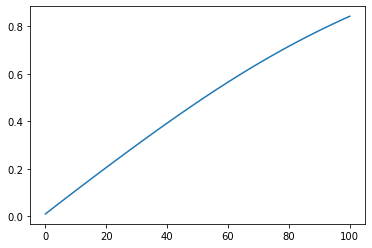

In [20]:
import matplotlib.pyplot as plt
plt.plot( average_force)

print(average_force)

# Equation


Inline equation $x$

\begin{equation*}
1 +  \frac{q^2}{(1-q)}+\frac{q^6}{(1-q)(1-q^2)}+\cdots =
\prod_{j=0}^{\infty}\frac{1}{(1-q^{5j+2})(1-q^{5j+3})},
\quad\quad \text{for $|q|<1$}.
\end{equation*}